## Семинар 4: "Сверточные сети"

ФИО: Смирнов Егор Геннадьевич

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import clear_output
%matplotlib inline

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [2]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal)-len(kernel)+1)
    # 1. не забудьте перевернуть ядро!
    # 2. необходимо реализовать свертку без отступов, т.е. 
    #   размер результирующего сигнала должен быть меньше входного.
    
    for i in range(signal_convolved.shape[0]):
        signal_convolved[i] = np.sum(kernel[::-1] * signal[i:i+len(kernel)])
    
    """
    kernel_h = len(kernel) // 2
    for i in range(kernel_h, signal.shape[0] - kernel_h):
        k = i - kernel_h
        signal_convolved[k] = np.sum(kernel[::-1] * signal[i-kernel_h:i+kernel_h+1])
    """
        
    return signal_convolved

Проверим правильность реализации, сравнив с реализацией из scipy

In [3]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

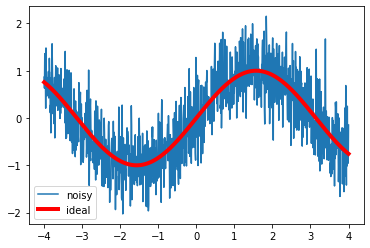

In [4]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку <b>зашумленного</b> сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [5]:
kernel = np.ones(71)
kernel /= kernel.shape[0]

denoised_signal = convolve(noisy_signal, kernel, 'same')

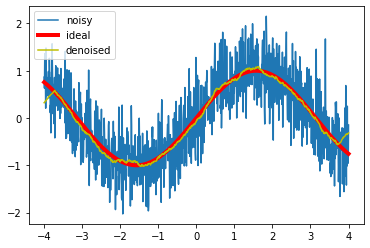

In [6]:
x = np.linspace(-4, 4, 1000)
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x, denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

In [7]:
for size in range(3, 999, 2):
    kernel = np.ones(size)
    kernel /= kernel.shape[0]

    denoised_signal = convolve(noisy_signal, kernel, 'same')    
    error = ((signal - denoised_signal)**2).mean()
    
    print("ks = {}, error = {}".format(size, error))

ks = 3, error = 0.07655038103630292
ks = 5, error = 0.04356530341207359
ks = 7, error = 0.0317582718337512
ks = 9, error = 0.02530617393633096
ks = 11, error = 0.020984130435350638
ks = 13, error = 0.01788803582940065
ks = 15, error = 0.015827965930194858
ks = 17, error = 0.01418603284114414
ks = 19, error = 0.012760271853706614
ks = 21, error = 0.011671272357023782
ks = 23, error = 0.010783403132339572
ks = 25, error = 0.010116175495376474
ks = 27, error = 0.009544803334417266
ks = 29, error = 0.009098314190940496
ks = 31, error = 0.00875628180521116
ks = 33, error = 0.008518312040048662
ks = 35, error = 0.008304583251981516
ks = 37, error = 0.00811863885962919
ks = 39, error = 0.00800174659491416
ks = 41, error = 0.007872016363946343
ks = 43, error = 0.007790199306554178
ks = 45, error = 0.007701824902222262
ks = 47, error = 0.007609464613790351
ks = 49, error = 0.007516976400550581
ks = 51, error = 0.00744481953360215
ks = 53, error = 0.00736356042376002
ks = 55, error = 0.007312361

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

In [8]:
image = plt.imread('image.jpg')

FileNotFoundError: [Errno 2] No such file or directory: 'image.jpg'

In [9]:
image.shape

NameError: name 'image' is not defined

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [15]:
color_to_bw = np.array([0.2989, 0.5870, 0.1140])

In [16]:
arr = np.array([[[3, 3, 3], [1, 1, 1]], [[3, 3, 3], [1, 1, 1]]])

In [17]:
arr.flatten()

array([3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 1, 1])

In [18]:
image.shape

(2448, 3264, 3)

In [19]:
image.flatten().shape

(23970816,)

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

In [10]:
bw_image = convolve(image.flatten(), color_to_bw, 'same')[::3].reshape(*image.shape[:2])
#convolve(noisy_signal, kernel, 'same')
# Не забудьте, что размер bw_image должен быть [w,h], а convolve вам вернет [w,h,1]
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

NameError: name 'image' is not defined

TypeError: Invalid shape (3,) for image data

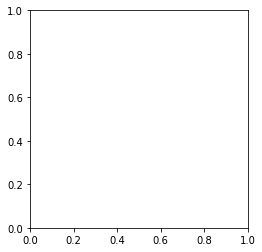

In [21]:
plt.imshow(color_to_bw, cmap=plt.cm.Greys_r)

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро <a href="https://ru.wikipedia.org/wiki/Оператор_Собеля">фильтра Собеля</a> и продемонстрируйте результат его применения к любому цветному изображению.</i>

In [62]:
from scipy.signal import convolve2d

kernel = np.array([[-1, -2, -1],
                   [0,   0,  0],
                   [+1, +2, +1]])

res_y = convolve2d(bw_image, kernel.T, 'same')
res_x = convolve2d(bw_image, kernel, 'same')

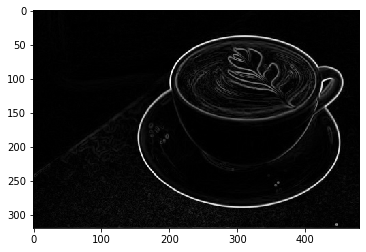

In [68]:
plt.imshow((res_x**2 + res_y**2)**0.5, cmap=plt.cm.Greys_r)

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [91]:
#[10, 30, 3] -> [10, 30, 4]
#[3, 3, 3, 4]

def t_convolve_bank(signal, kernel):
    assert signal.shape[-1] == kernel.shape[0]
    
    res = []
    for i in range(kernel.shape[-1]):
        r = np.zeros_like(signal[:, :, i])
        for j in range(signal.shape[-1]):
            r += convolve2d(signal[:, :, j], kernel[j, :, :, i], 'same')            
        
        res.append(r)
    
    return np.array(res).transpose((1, 2, 0))

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [94]:
#RGB -> RBG

kernels = np.zeros((3, 1, 1, 3))

kernels[0, 0, 0, 0] = 1
kernels[1, 0, 0, 0] = 1

kernels[2, 0, 0, 1] = 1

kernels[1, 0, 0, 2] = 1
kernels[2, 0, 0, 2] = 1

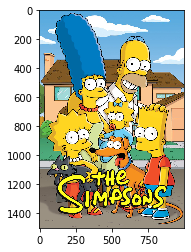

In [73]:
image = plt.imread("simpsons.jpg") 
plt.imshow(image)

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

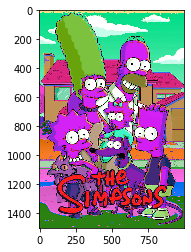

In [95]:
res_image = t_convolve_bank(image.astype(float), kernels)

plt.imshow(res_image.astype('uint8'))

# Не забудьте, что после свертки вы скорее всего получите тензор типа float. 
# Чтобы imshow нормально отобразил результат, надо привести его к типу uint8 (нпр., при помощи .astype('uint8'))

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [22]:
def maxpool(image, w=2):
    assert(image.ndim == 3)
    
    res = np.zeros((image.shape[0] // w, image.shape[1] // w, image.shape[2]))
    for i in range(0, image.shape[0], w):
        for j in range(0, image.shape[1], w):
            for k in range(image.shape[2]):
                res[i//w, j//w, k] = np.max(image[i:i+w, j:j+w, k])
                
    return res
    

def medianpool(image, w=2):
    assert(image.ndim == 3)
    
    res = np.zeros((image.shape[0] // w, image.shape[1] // w, image.shape[2]))
    for i in range(0, image.shape[0], w):
        for j in range(0, image.shape[1], w):
            for k in range(image.shape[2]):
                res[i//w, j//w, k] = np.median(image[i:i+w, j:j+w, k])
                
    return res

In [23]:
res_image = maxpool(image.astype(float))

plt.imshow(res_image.astype('uint8'))

KeyboardInterrupt: 

Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

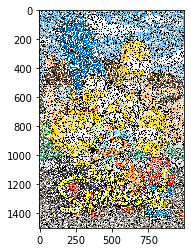

In [125]:
frac = 0.7

res_image = np.array(image)

ind = np.random.rand(*image.shape[:2]) > frac
res_image[ind, :] = 0

ind = np.random.rand(*image.shape[:2]) > frac
res_image[ind, :] = 255

plt.imshow(res_image.astype('uint8'))

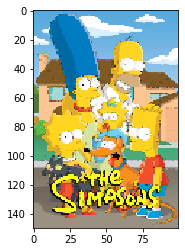

In [128]:
clean_image = medianpool(res_image.astype(float), 10)

plt.imshow(clean_image.astype('uint8'))

<i>2.3 Какой тип пулинга лучше справился с поставленной задачей? Почему?</i>

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax
1. input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [14]:
!conda install requests --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/miniconda3/envs/neural-py37

  added / updated specs:
    - requests


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    brotlipy-0.7.0             |py37h9ed2024_1003         333 KB
    cffi-1.14.5                |   py37h2125817_0         214 KB
    chardet-4.0.0              |py37hecd8cb5_1003         194 KB
    cryptography-3.3.1         |   py37hbcfaee0_1         559 KB
    pysocks-1.7.1              |   py37hecd8cb5_0          31 KB
    ------------------------------------------------------------
                                           Total:         1.3 MB

The following NEW packages will be INSTALLED:

  brotlipy           pkgs/main/osx-64::brotlipy-0.7.0-py37h9ed2024_1003
  cffi               pkgs/main/osx-64::cffi-1.14.5-py37h2125817_0
  chardet            pkgs/main/osx-64::chardet-4.0.0-py37hecd8cb5_10

In [15]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys

In [16]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

99.5%

102.8%


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


100.0%


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


112.7%
/opt/miniconda3/envs/neural-py37/lib/python3.7/site-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1614378044816/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


In [41]:
# пример сверточной сети

image_size = 28
channels = 1
class ConvClassifier_1(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(channels, channels * 8, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(nn.Conv2d(channels * 8, channels * 16, 3, 1, 1), nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(image_size // 2 * image_size // 2 * 16, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [52]:
def train(network, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

Epoch 4... (Train/Test) NLL: 0.082/0.069	Accuracy: 0.976/0.978


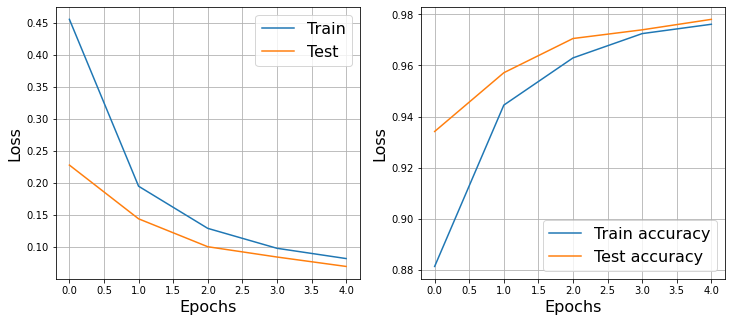

In [43]:
network = ConvClassifier_1(image_size=28)
train(network, 5, 1e-4)

<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

In [44]:
class ConvClassifier_2(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(channels, channels * 8, 3, 1, 1), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Conv2d(channels * 8, channels * 16, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(nn.Conv2d(channels * 16, channels * 32, 3, 1, 1))
        self.linear_layers = nn.Sequential(nn.Linear(image_size // 2 * image_size // 2 * 32, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x) 
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.064/0.056	Accuracy: 0.981/0.982


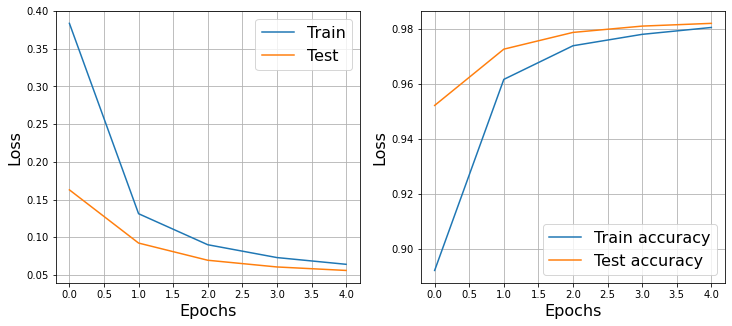

In [45]:
network = ConvClassifier_2(image_size=28)
train(network, 5, 1e-4)

Сеть с второй архитектурой справилась получше.

Полносвязные сети давали, конечно, хуже результат. Там с аугментацией максимум 0.98 набивался на тесте за 20 эпох, а тут за 5 эпох, решение почти из коробки дает скор уже 0.982 на тесте. Выбор очевиден

<i>3.2 На каких объектах сеть ошибается сильнее всего? Нарисуйте эти объекты с правильными и предсказаными метками.</i>

In [71]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    prediction = network(X).data.numpy()
    for i in range(prediction.shape[0]):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

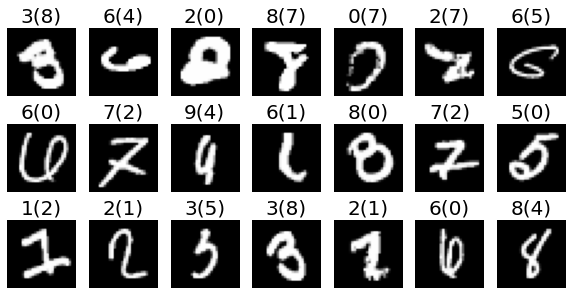

In [72]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

На некоторых изображениях грех не ошибиться, если честно. А так, есть и достаточно простые изображения

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

In [77]:
class ConvClassifier_result(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.cnnLayer = nn.Sequential(
            # input 1 x 28 x 28
            nn.Conv2d(1, 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size 8 x 14 x 14
            nn.Conv2d(8, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 16 x 7 x 7
            nn.Conv2d(16, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 32 x 3 x 3
            nn.MaxPool2d(2, 2)
            # state size. 32 x 1 x 1
        )
        self.layer_exit = nn.Sequential(nn.Linear(32 * 1 * 1, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.cnnLayer(x)
        x = x.view(x.size(0), -1)
        out = self.layer_exit(x)
        return out

Epoch 19... (Train/Test) NLL: 0.037/0.055	Accuracy: 0.990/0.983


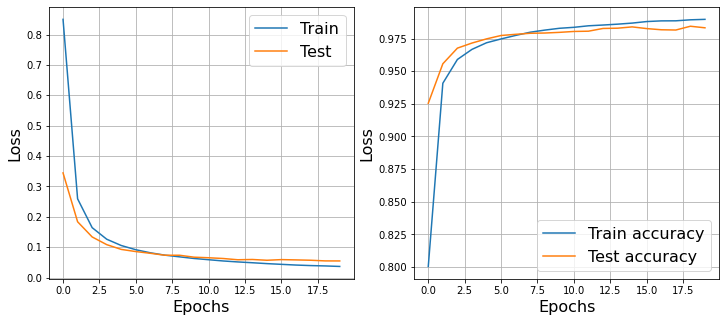

In [78]:
network_res = ConvClassifier_result(image_size=28)
train(network_res, 20, 1e-4)

Переобучились малость. Но 0.983 на тесте неплохо

In [115]:
class ConvClassifier_attempt(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.cnnLayer = nn.Sequential(
            # input 1 x 28 x 28
            nn.Conv2d(1, 20, 4, 1, 2, bias=False),
            nn.BatchNorm2d(20),
            nn.LeakyReLU(0.2, inplace=True),
            # state size 20 x 28 x 28
            nn.MaxPool2d(2, 2),
            # state size. 20 x 14 x 14
            nn.Conv2d(20, 20, 4, 1, 2, bias=False),
            nn.BatchNorm2d(20),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 20 x 14 x 14
            nn.MaxPool2d(2, 2)
            # state size. 20 x 7 x 7
        )
        self.layer_exit = nn.Sequential(nn.Linear(20 * 7 * 7, 100), nn.ReLU(), nn.Linear(100, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.cnnLayer(x)
        x = x.view(x.size(0), -1)
        out = self.layer_exit(x)
        return out

Epoch 14... (Train/Test) NLL: 0.009/0.029	Accuracy: 0.997/0.991


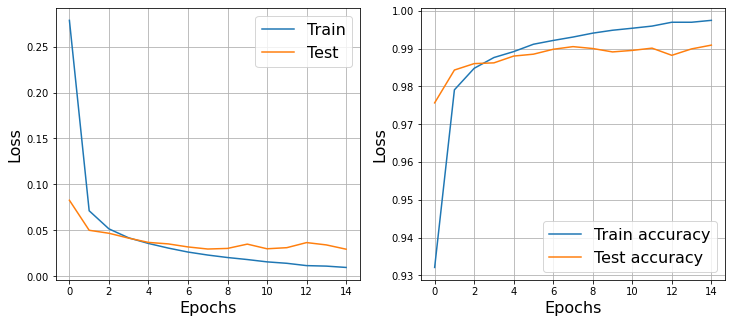

In [116]:
network_res = ConvClassifier_attempt(image_size=28)
train(network_res, 20, 1e-4)

Получше. 0.991 было!! Колеблемся на уровне 0.99. Думаю, неплохо!

In [117]:
class ConvClassifier_last(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.cnnLayer = nn.Sequential(
            # input 1 x 28 x 28
            nn.Conv2d(1, 20, 4, 2, 1, bias=False),
            nn.BatchNorm2d(20),
            nn.LeakyReLU(0.2, inplace=True),
            # state size 20 x 14 x 14
            nn.MaxPool2d(2, 2),
            # state size. 20 x 7 x 7
            nn.Conv2d(20, 20, 4, 2, 1, bias=False),
            nn.BatchNorm2d(20),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 20 x 3 x 3
            nn.Conv2d(20, 40, 3, 1, 1, bias=False),
            nn.BatchNorm2d(40),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(40, 40, 3, 1, 1, bias=False),
            nn.BatchNorm2d(40),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2)
            # state size. 40 x 1 x 1
        )
        self.layer_exit = nn.Sequential(nn.Linear(40 * 1 * 1, 256), nn.ReLU(), nn.Linear(256, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.cnnLayer(x)
        x = x.view(x.size(0), -1)
        out = self.layer_exit(x)
        return out

Epoch 14... (Train/Test) NLL: 0.010/0.052	Accuracy: 0.997/0.986


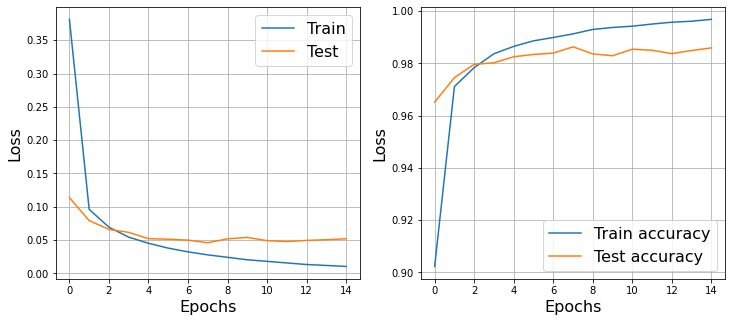

In [118]:
network_res = ConvClassifier_last(image_size=28)
train(network_res, 15, 1e-4)

Сильное переобучение.. Но точность неплохая, до 0.987 поднимались. Думаю, поможет Dropout

In [119]:
class ConvClassifier_last_with_dr(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.cnnLayer = nn.Sequential(
            # input 1 x 28 x 28
            nn.Conv2d(1, 20, 4, 2, 1, bias=False),
            nn.BatchNorm2d(20),
            nn.LeakyReLU(0.2, inplace=True),
            # state size 20 x 14 x 14
            nn.MaxPool2d(2, 2),
            # state size. 20 x 7 x 7
            nn.Conv2d(20, 20, 4, 2, 1, bias=False),
            nn.BatchNorm2d(20),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 20 x 3 x 3
            nn.Conv2d(20, 40, 3, 1, 1, bias=False),
            nn.BatchNorm2d(40),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(40, 40, 3, 1, 1, bias=False),
            nn.BatchNorm2d(40),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
            nn.MaxPool2d(2, 2)
            # state size. 40 x 1 x 1
        )
        self.layer_exit = nn.Sequential(nn.Linear(40 * 1 * 1, 256), nn.ReLU(), nn.Dropout(0.1), nn.Linear(256, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.cnnLayer(x)
        x = x.view(x.size(0), -1)
        out = self.layer_exit(x)
        return out

Epoch 14... (Train/Test) NLL: 0.018/0.050	Accuracy: 0.994/0.985


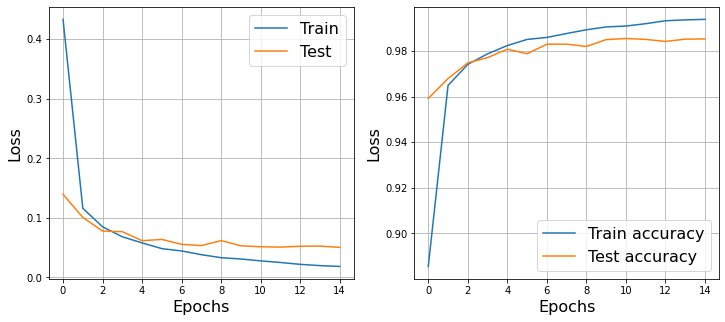

In [120]:
network_res = ConvClassifier_last_with_dr(image_size=28)
train(network_res, 15, 1e-4)

Грустно.. ну 0.985 есть. Переобучение меньше

In [121]:
class ConvClassifier_new(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.cnnLayer = nn.Sequential(
            # input 1 x 28 x 28
            nn.Conv2d(1, 32, 5, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # input 32 x 13 x 13
            nn.Conv2d(32, 64, 5, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # input 64 x 5 x 5
        )
        self.layer_exit = nn.Sequential(nn.Linear(64 * 5 * 5, 256), nn.ReLU(), nn.Linear(256, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.cnnLayer(x)
        x = x.view(x.size(0), -1)
        out = self.layer_exit(x)
        return out

Epoch 19... (Train/Test) NLL: 0.003/0.030	Accuracy: 0.999/0.992


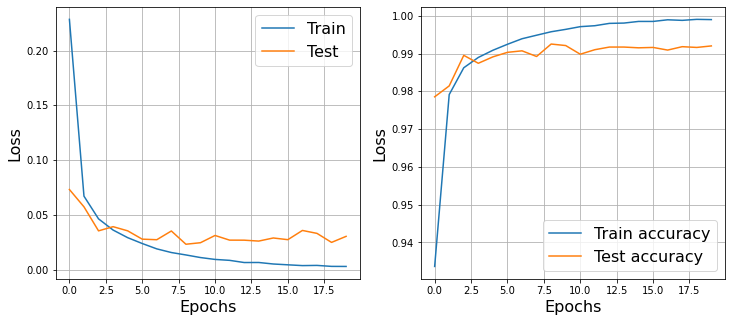

In [122]:
network_res = ConvClassifier_new(image_size=28)
train(network_res, 20, 1e-4)

Пока лучшая архитектура.. 0.993 было на 9 эпохе!!

Думаю, результат неплох.

Алгоритм сошелся к 15 эпохе, и точность 0.992 и переобучились не так сильно

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Оставлю здесь формулу для нахождения размера выходного изображения после операции свертки $$ W_{out} = (W_{in} - Kernel + 2*padding ) / stride + 1 $$ 

Очень удобно.. Пусть полежит в этом нотбуке

Здесь вы можете оставить комментарии по лекции или семинару: